In [1]:
import gensim, os
from gensim.models.word2vec import Word2Vec


# set file names for train and test data
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test','test_data']) + os.sep

# os.sep : Character used by windows to separate path names
lee_train_file = test_data_dir + 'lee_background.cor'

# .cor : Native to CorelDRAW software

In [2]:
class MyText(object):
    
    def __iter__(self):
        
        for line in open(lee_train_file):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()
            
            # yield : return from a function without destroying the states of its local
            # variable and when the function is called, execution starts from last yield 
            # statement
            
            # Any function that contains a 'yield' keyword is called a "Generator"
            
sentences = MyText()

model = Word2Vec(sentences, min_count = 1)

print(model)
            
            

Word2Vec(vocab=10186, size=100, alpha=0.025)


Running the timing cells below more than once gives subsequent timings close to 0, as 
cached objects are used. To get accurate timings, run these cells from a freshly started Kernel

In [3]:
# Set up model and vector that we are using in comparison

try:
    from gensim.similarities.index import AnnoyIndexer

except ImportError:
    raise ValueError("SKIP: Please install Annoy Indexer")
    
model.init_sims()
vector = model.wv.syn0norm[0]

# Details on syn0norm :
# https://stackoverflow.com/questions/53301916/python-gensim-what-is-the-meaning-of-syn0-and-syn0norm

#vector = model.vectors_norm[0]
annoy_index = AnnoyIndexer(model, 500)
    

<ipython-input-3-84aed5ef81e3>:10: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  vector = model.wv.syn0norm[0]
/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:198: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


In [4]:
%%time
# Tradition Implementation:
model.wv.most_similar([vector], topn = 5)

CPU times: user 6.59 ms, sys: 126 µs, total: 6.72 ms
Wall time: 31 ms


[('the', 1.0),
 ('a', 0.9999880790710449),
 ('for', 0.9999862313270569),
 ('and', 0.9999852776527405),
 ('from', 0.9999850988388062)]

In [5]:
%%time 

# Annoy Implementation:

neighbors = model.most_similar([vector], topn = 5, indexer = annoy_index)

for neighbor in neighbors:
    print(neighbor)

('a', 0.99757697340101)
('after', 0.9968355759046972)
('two', 0.9962853700853884)
('into', 0.996217789594084)
('first', 0.9961436598096043)
CPU times: user 10.2 ms, sys: 199 µs, total: 10.4 ms
Wall time: 2.41 ms


<timed exec>:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



**What is Annoy?**

Annoy is an open source library to search for points in space that are close to a given query point. It also creates large read-only file-based data structures that are mmapped into memory so that many processes may share the same data. For our purpose, it is used to find similarity between words or documents in a vector space. See the tutorial on similarity queries for more information on them.


**Getting Started**

In [6]:
# import modules and set up logging
import logging

# Tracks events that happen when some software executes.
logging.basicConfig(format='%(asctime)s : %(levelname)s: %(message)s', level = logging.INFO)

**Making a Similarity Query**

**Creating an Indexer**

An instance of AnnoyIndexer needs to be created in order to use Annoy in gensim. 
The AnnoyIndexer class is located in gensim.similarities.index

AnnoyIndexer() takes 2 parameters: 

**model**: A Word2Vec or Doc2Vec model

**num_trees:** Positive integer, num_trees effects the build time and index size. 
            **A larger value will give more accurate results, but larger indexes**.
            More information on what trees in Annoy can do is found here : https://github.com/spotify/annoy#how-does-it-work
            
            

Relation between num_trees, build time and accuracy will be investigated later

In [7]:
from gensim.similarities.index import AnnoyIndexer
# 100 trees are being used 
annoy_index = AnnoyIndexer(model, 100)

Lets find top 5 most similar words to "army" in the corpus.
To make similarity we call Word2Vec.most_similar like we  would traditionally, with ana dded parameter, indexer. 

**Only supported indexer in gensim for now is Annoy**

In [8]:
%%time

# Dervie vector for word "army" in our model
vector = model.wv["army"]

# instance of AnnoyIndexer we just created is passed
approximate_neighbors = model.wv.most_similar([vector], topn=5, indexer=annoy_index)

# Neatly print approximate neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print(neighbor)

('who', 0.9873399483039975)
('us', 0.9873364176601171)
('they', 0.9870697623118758)
('that', 0.9866892965510488)
('was', 0.9866568706929684)
CPU times: user 2.11 ms, sys: 37 µs, total: 2.15 ms
Wall time: 911 µs


**Analyzing the results**

Closer cosine similarity of a vector is to 1 , more similar that word is to our query. 
Which was the vector for "army"


**Persisting Indexes**

You can save and load your indexes from/to disk to prevent having to construct them each time. 
This will create 2 files on disk, **fname and fname.d**
Both files are needed to correctly restore all attributes. 
Before loading an index, you'll have to create an empty AnnoyIndexer object

**.d is a Dependency file**
Contains dependencies in plain text that describe the files that were used to create compiled object files (.o files) by a c compiler

In [9]:
fname = 'index'

# Persist index to disk
annoy_index.save(fname)

# Load index back
if os.path.exists(fname):
    annoy_index2 = AnnoyIndexer()
    annoy_index2.load(fname)
    annoy_index2.model = model

/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:168: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])


In [10]:
%%time

# Results should be identicalto above model
vector = model.wv["army"]

approximate_neighbors = model.wv.most_similar([vector], topn=5, indexer=annoy_index2)
for neighbor in approximate_neighbors:
    print(neighbor)

('who', 0.9873399483039975)
('us', 0.9873364176601171)
('they', 0.9870697623118758)
('that', 0.9866892965510488)
('was', 0.9866568706929684)
CPU times: user 3.3 ms, sys: 63 µs, total: 3.36 ms
Wall time: 2.6 ms


**Save memory by Memory-Mapping indices saved to disk**

Annoy library has a useful feature that indices can be memory-mapped from disk. 
Saves memory when same index is used by several processes.

Below are 2 snippets of code. 
1st one has a separate index for each process. 
2nd snipped shares index between 2 processes via Memory-mapping. 
**2nd example uses less total RAM as it's shared.**

In [11]:
%%time 

# Bad Example : 2 processes load the Word2Vec model from disk and create their own Annoy 
# indices from that model. 

from gensim import models
from gensim.similarities.index import AnnoyIndexer
from multiprocessing import Process
import os
import psutil


CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 15.3 ms


**PSUTIL:** Cross-platform library for retrieving info on running processes and System    utilization

Useful for System monitoring, profiling, limiting process resources and management of running processes.

**Multi-Processing:** Package that supports spawning processes using an API similar to threading midule

Offers both local and remote Concurrency


In [12]:
%%time

# Bad example. Two processes load the Word2vec model from disk and create there own Annoy indices from that model. 

from gensim import models
from gensim.similarities.index import AnnoyIndexer
from multiprocessing import Process
import os
import psutil

model.save('/tmp/mymodel')

def f(process_id):
    print('Process ID:', os.getpid())
    process = psutil.Process(os.getpid())
    new_model = models.Word2Vec.load('/tmp/mymodel')
    vector= new_model.wv["army"]
    annoy_index = AnnoyIndexer(new_model, 100)
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    
    for neighbor in approximate_neighbors:
        print(neighbor)
        
    print('Memory used by process'+str(os.getpid())+'=', process.memory_info())
    
# Creating and running 2 parallel process to share same index file. 
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

2020-08-20 08:26:43,032 : INFO: saving Word2Vec object under /tmp/mymodel, separately None
2020-08-20 08:26:43,034 : INFO: not storing attribute vectors_norm
2020-08-20 08:26:43,036 : INFO: not storing attribute cum_table
2020-08-20 08:26:43,211 : INFO: saved /tmp/mymodel


Process ID: 24130


2020-08-20 08:26:43,232 : INFO: loading Word2Vec object from /tmp/mymodel
2020-08-20 08:26:43,373 : INFO: loading wv recursively from /tmp/mymodel.wv.* with mmap=None
2020-08-20 08:26:43,374 : INFO: setting ignored attribute vectors_norm to None
2020-08-20 08:26:43,375 : INFO: loading vocabulary recursively from /tmp/mymodel.vocabulary.* with mmap=None
2020-08-20 08:26:43,376 : INFO: loading trainables recursively from /tmp/mymodel.trainables.* with mmap=None
2020-08-20 08:26:43,377 : INFO: setting ignored attribute cum_table to None
2020-08-20 08:26:43,378 : INFO: loaded /tmp/mymodel
2020-08-20 08:26:43,398 : INFO: precomputing L2-norms of word weight vectors
/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:198: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


('who', 0.9873399483039975)
('us', 0.9873364176601171)
('they', 0.9870697623118758)
('that', 0.9866892965510488)
('was', 0.9866568706929684)
Memory used by process24130= pmem(rss=169492480, vms=1188462592, shared=16076800, text=2420736, lib=0, data=210677760, dirty=0)
Process ID: 24164


2020-08-20 08:26:44,555 : INFO: loading Word2Vec object from /tmp/mymodel
2020-08-20 08:26:44,688 : INFO: loading wv recursively from /tmp/mymodel.wv.* with mmap=None
2020-08-20 08:26:44,689 : INFO: setting ignored attribute vectors_norm to None
2020-08-20 08:26:44,690 : INFO: loading vocabulary recursively from /tmp/mymodel.vocabulary.* with mmap=None
2020-08-20 08:26:44,691 : INFO: loading trainables recursively from /tmp/mymodel.trainables.* with mmap=None
2020-08-20 08:26:44,692 : INFO: setting ignored attribute cum_table to None
2020-08-20 08:26:44,693 : INFO: loaded /tmp/mymodel
2020-08-20 08:26:44,703 : INFO: precomputing L2-norms of word weight vectors
/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:198: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


('who', 0.9873399483039975)
('us', 0.9873364176601171)
('they', 0.9870697623118758)
('that', 0.9866892965510488)
('was', 0.9866568706929684)
Memory used by process24164= pmem(rss=169312256, vms=1188462592, shared=15843328, text=2420736, lib=0, data=210714624, dirty=0)
CPU times: user 98.4 ms, sys: 56.3 ms, total: 155 ms
Wall time: 2.88 s


In [13]:
%%time 

# Good Example: 2 processes load both the Word2Vec model and index from disk and 
# memory-map the index

from gensim import models
from gensim.similarities.index import AnnoyIndexer
from multiprocessing import Process
import os 
import psutil

model.save('/tmp/mymodel')

def f(process_id):
    
    print('Process ID:', os.getpid())
    process = psutil.Process(os.getpid())
    new_model = models.Word2Vec.load('/tmp/mymodel')
    vector = new_model.wv["army"]
    annoy_index = AnnoyIndexer()
    annoy_index.load('index')
    annoy_index.model = new_model
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    
    for neighbor in approximate_neighbors:
        print(neighbor)
        
    print("Memory used by Process "+str(os.getpid()), process.memory_info())
    
# Creating and running 2 parallel process to share the same index file

p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('1',))
p2.start()
p2.join()

2020-08-20 08:26:45,926 : INFO: saving Word2Vec object under /tmp/mymodel, separately None
2020-08-20 08:26:45,928 : INFO: not storing attribute vectors_norm
2020-08-20 08:26:45,929 : INFO: not storing attribute cum_table
2020-08-20 08:26:46,119 : INFO: saved /tmp/mymodel


Process ID: 24198


2020-08-20 08:26:46,144 : INFO: loading Word2Vec object from /tmp/mymodel
2020-08-20 08:26:46,289 : INFO: loading wv recursively from /tmp/mymodel.wv.* with mmap=None
2020-08-20 08:26:46,290 : INFO: setting ignored attribute vectors_norm to None
2020-08-20 08:26:46,291 : INFO: loading vocabulary recursively from /tmp/mymodel.vocabulary.* with mmap=None
2020-08-20 08:26:46,292 : INFO: loading trainables recursively from /tmp/mymodel.trainables.* with mmap=None
2020-08-20 08:26:46,293 : INFO: setting ignored attribute cum_table to None
2020-08-20 08:26:46,293 : INFO: loaded /tmp/mymodel
/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:168: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])
2020-08-20 08:26:46,306 : INFO: precomputing L2-norms of word weight vectors


('who', 0.9873399483039975)
('us', 0.9873364176601171)
('they', 0.9870697623118758)
('that', 0.9866892965510488)
('was', 0.9866568706929684)
Memory used by Process 24198 pmem(rss=177143808, vms=1189470208, shared=25776128, text=2420736, lib=0, data=194338816, dirty=0)
Process ID: 24231


2020-08-20 08:26:46,335 : INFO: loading Word2Vec object from /tmp/mymodel
2020-08-20 08:26:46,477 : INFO: loading wv recursively from /tmp/mymodel.wv.* with mmap=None
2020-08-20 08:26:46,478 : INFO: setting ignored attribute vectors_norm to None
2020-08-20 08:26:46,479 : INFO: loading vocabulary recursively from /tmp/mymodel.vocabulary.* with mmap=None
2020-08-20 08:26:46,480 : INFO: loading trainables recursively from /tmp/mymodel.trainables.* with mmap=None
2020-08-20 08:26:46,481 : INFO: setting ignored attribute cum_table to None
2020-08-20 08:26:46,482 : INFO: loaded /tmp/mymodel
/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:168: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])
2020-08-20 08:26:46,502 : INFO: precomputing L2-norms of word weight vectors


('who', 0.9873399483039975)
('us', 0.9873364176601171)
('they', 0.9870697623118758)
('that', 0.9866892965510488)
('was', 0.9866568706929684)
Memory used by Process 24231 pmem(rss=176840704, vms=1189470208, shared=25448448, text=2420736, lib=0, data=194355200, dirty=0)
CPU times: user 104 ms, sys: 36.6 ms, total: 140 ms
Wall time: 596 ms


**RELATIONSHIP BETWEEN NUM_TREES AND INITIALIZATION TIME**



/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:198: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


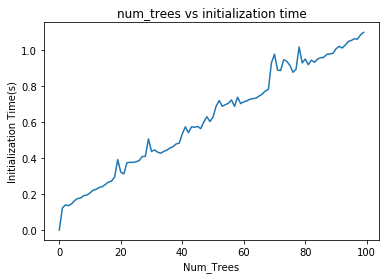

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt, time

x_cor = []
y_cor = []

for x in range(100):
    
    start_time = time.time()
    AnnoyIndexer(model, x)
    y_cor.append(time.time() - start_time)
    x_cor.append(x)
    
plt.plot(x_cor, y_cor)

plt.title("num_trees vs initialization time")
plt.ylabel("Initialization Time(s)")
plt.xlabel("Num_Trees")
plt.show()

**Relationship between num_trees and accuracy**

<ipython-input-19-2ee549bae6fe>:1: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  exact_results = [element[0] for element in model.wv.most_similar([model.wv.syn0norm[0]], topn=100)]
/home/nishant/miniconda3/envs/pysyft/lib/python3.8/site-packages/gensim/similarities/index.py:198: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)
<ipython-input-19-2ee549bae6fe>:6: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  approximate_results = model.most_similar([model.wv.syn0norm[0]], topn=100, indexer=annoy_index)
<ipython-input-19-2ee549bae6fe>:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  approximate_results = model.most_similar([model.wv.syn0norm[0]],

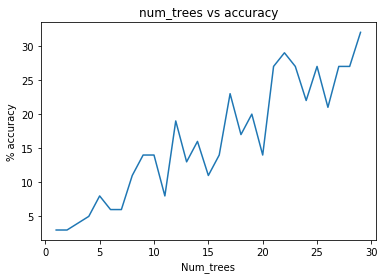

In [19]:
exact_results = [element[0] for element in model.wv.most_similar([model.wv.syn0norm[0]], topn=100)]
x_axis = []
y_axis = []
for x in range(1, 30):
    annoy_index = AnnoyIndexer(model, x)
    approximate_results = model.most_similar([model.wv.syn0norm[0]], topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    x_axis.append(x)
    y_axis.append(len(set(top_words).intersection(exact_results)))
    
plt.plot(x_axis, y_axis)
plt.title("num_trees vs accuracy")
plt.ylabel("% accuracy")
plt.xlabel("Num_trees")
plt.show()